In [1]:
import pandas as pd
import numpy as np
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
import seaborn as sns

In [2]:
df=pd.read_csv('../data/processed_train_filled.csv')

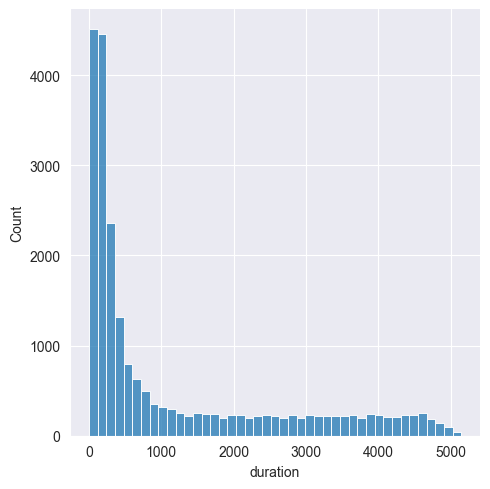

In [3]:
sns.displot(df['duration'])

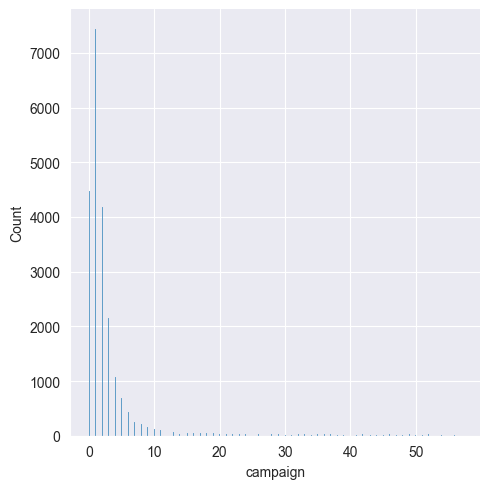

In [4]:
sns.displot(df['campaign'])

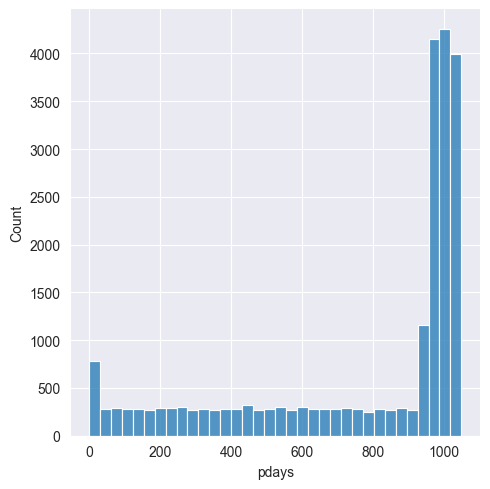

In [5]:
sns.displot(df['pdays'])

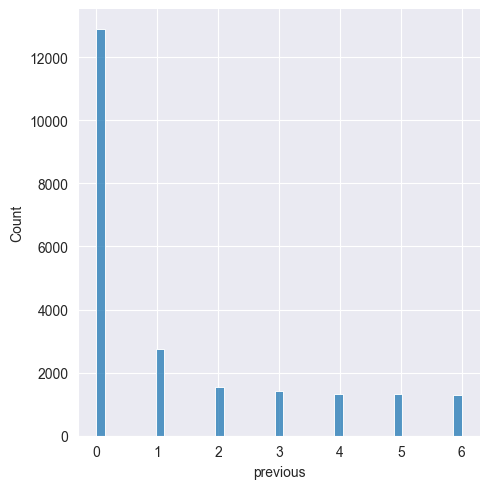

In [6]:
sns.displot(df['previous'])

In [7]:
# Group the duration by duration <= 1000 and duration > 1000
# Group the campaign by campaign <= 10 and campaign > 10
# Group the pdays by pdays > 900 and pdays <= 900

In [8]:
cust_features_transform = ['job', 'education', 'marital', 'contact']
cust_features_map = ['default', 'housing', 'loan', 'subscribe']

In [9]:
df['duration_gp'] = df['duration'].apply(lambda x: 1 if x <= 1000 else 0)
df['campaign_gp'] = df['campaign'].apply(lambda x: 1 if x <= 10 else 0)
df['pdays_gp'] = df['pdays'].apply(lambda x: 1 if x > 900 else 0)
for feature in cust_features_transform:
    encoder = OneHotEncoder(sparse_output=False)
    feature_df = pd.DataFrame(encoder.fit_transform(df[[feature]]),
                              columns=encoder.get_feature_names_out([feature])).reset_index(drop=True)
    df = pd.concat([df, feature_df], axis=1)
for feature in cust_features_map:
    feature_df = df[feature].map({'yes':1, 'no':0})
    df = pd.concat([df, feature_df], axis=1)

In [10]:
X = df.iloc[:,22:-1]
y = df.iloc[:,-1]

       duration_gp  campaign_gp  pdays_gp  job_admin.  job_blue-collar  \
0                0            1         0         1.0              0.0   
1                0            1         0         0.0              0.0   
2                1            1         1         0.0              1.0   
3                1            0         1         0.0              0.0   
4                0            1         0         1.0              0.0   
...            ...          ...       ...         ...              ...   
22495            0            1         1         1.0              0.0   
22496            0            0         0         1.0              0.0   
22497            0            1         0         1.0              0.0   
22498            1            1         1         0.0              0.0   
22499            1            1         1         0.0              1.0   

       job_entrepreneur  job_housemaid  job_management  job_retired  \
0                   0.0            0.0  

In [11]:
for k in range(31, 60):
    steps = [('smote', SMOTE(random_state=99)), ('knn', KNeighborsClassifier(n_neighbors=k, weights='distance'))]
    pipeline = Pipeline(steps)
    scores = cross_val_score(pipeline, X, y, cv=10, scoring='f1_macro').mean()
    print("When k=%d, accuracy=%.5f" % (k, scores))

When k=31, accuracy=0.58974
When k=32, accuracy=0.58897
When k=33, accuracy=0.58962
When k=34, accuracy=0.59106
When k=35, accuracy=0.59044
When k=36, accuracy=0.59092
When k=37, accuracy=0.59078
When k=38, accuracy=0.59076
When k=39, accuracy=0.59039
When k=40, accuracy=0.59087
When k=41, accuracy=0.58995
When k=42, accuracy=0.59056
When k=43, accuracy=0.59112
When k=44, accuracy=0.59053
When k=45, accuracy=0.58989
When k=46, accuracy=0.58988
When k=47, accuracy=0.58917
When k=48, accuracy=0.58923
When k=49, accuracy=0.58944
When k=50, accuracy=0.58967
When k=51, accuracy=0.58868
When k=52, accuracy=0.58984
When k=53, accuracy=0.58894
When k=54, accuracy=0.58865
When k=55, accuracy=0.58834
When k=56, accuracy=0.58831
When k=57, accuracy=0.58777
When k=58, accuracy=0.58861
When k=59, accuracy=0.58870


In [14]:
model_best = KNeighborsClassifier(n_neighbors=43,weights='distance')
model_best.fit(X,y)
y_pred_knn = cross_val_predict(model_best,X,y,cv=10)

steps = [('smote', SMOTE(random_state=99)), ('knn', KNeighborsClassifier(n_neighbors=43, weights='distance'))]
pipeline = Pipeline(steps)
pipeline.fit(X, y)
y_pred_smote = cross_val_predict(pipeline, X, y, cv=10)

# show a classification report demonstrating the accuracy of the classifier for each digit
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# evaluate result
print("Accuracy:",cross_val_score(model_best,X,y,cv=10).mean())
print("Confusion Matrix:\n", confusion_matrix(y_pred_knn, y))
print("Accuracy:",cross_val_score(pipeline,X,y,cv=10).mean())
print("Confusion Matrix:\n", confusion_matrix(y_pred_smote, y))

Accuracy: 0.8627555555555555
Confusion Matrix:
 [[19258  2798]
 [  290   154]]
Accuracy: 0.795911111111111
Confusion Matrix:
 [[16916  1960]
 [ 2632   992]]
